# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico III 


### NOTEBOOK No 3: Hyperparameter Optimization in Machine learning Models

## Introduction

This notebook corresponds to the second part of this exploration. This is a first incursion on supervised learning. Most of the techniques used were simple and come from a place of *"what would happen if"*.

In the last notebook, we saw the performance of song genre classifiers using the default hyperparameters.

In this notebook, the hyperparameters used will be picked in an optimal way, using gridsearch. In order to see the behavior with the raw dataset, we didn't normalize the data to see if there would be a big impact in the results. To reproduce this with a normalized dataset is proposed in the section **Future work**

#### Structure
1. A first part of this notebook is equivalent to the models_1 notebook; dataset and data split preparations and decisions. As a quick overview: our target feature is genre, Spotify's API gave us a list of genres for each artist. 
    1. First we tried using just one genre of all the possible genres of an artist, making it a classic multiclass problem. 
    2. Later we use the full list of genres, transforming the task to a multilabel multiclass problem.

2. Gridsearched classifiers.

### Dependencias y acceso a APIs

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm
import plotly.express as px
import plotly.graph_objects as go
import itertools
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from statistics import median,mean
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
sns.set_context(context='paper')

## Dataset
starting from here we have a full Dataset with all the track of the playlist plus audio features and the pre-processed sentiment analysis variable


In [25]:
songs_base = pd.read_csv("./final_big.csv",sep="#")
#let's get back our genres
songs_base["genres"]=songs_base["genres"].apply(lambda x: x.replace("[","").replace("]","").replace("'","").split(","))
songs_base["artists"]=songs_base["artists"].apply(lambda x: x.replace("[","").replace("]","").replace("'","").split(","))

In [26]:
songs_base.shape

(920, 9)

In [27]:
my_dataframe=songs_base.copy()

In [28]:
#SPLIT AUDIO FEATURES
import ast

audio_thing= my_dataframe["audio_features"].apply(lambda x: ast.literal_eval(x))
audio_features_base = pd.DataFrame(list(audio_thing))
audio_features = audio_features_base.columns

my_dataframe = my_dataframe.reset_index(drop=True)
audio_features_base = audio_features_base.reset_index(drop=True)
my_dataframe = pd.concat([my_dataframe,audio_features_base],axis=1)
print(my_dataframe.shape)
my_dataframe.head(1)

(920, 27)


,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key': 1, 'loudness': -11.21, 'mode': 0, 'speechiness': 0.0472, 'acousticness': 0.486, 'instrumentalness': 0.409, 'liveness': 0.371, 'valence': 0.0926, 'tempo': 161.092, 'type': 'audio_features', 'id': '7j9DYPyCuvSAtPcevpAkzb', 'uri': 'spotify:track:7j9DYPyCuvSAtPcevpAkzb', 'track_href': 'https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb', 'duration_ms': 233079, 'time_signature': 5}","[art pop, dance pop, deconstructed club, electropop, escape room, experimental pop, fluxwork, indie r&b, indietronica]",0.0013,0.486,https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb,0.161,233079,0.482,7j9DYPyCuvSAtPcevpAkzb,0.409,1,0.371,-11.21,0,0.0472,161.092,5,https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb,audio_features,spotify:track:7j9DYPyCuvSAtPcevpAkzb,0.0926


In [29]:
#EXTRACT FIRST ARTIST
my_dataframe1 = my_dataframe.copy()
my_dataframe1["first_artist"] = my_dataframe1["artists"].apply(lambda x: x[0])
print(my_dataframe1.shape)

(920, 28)


problem with spotify's genres (target): **multiple genres in the same song**

Examples:

In [30]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
my_dataframe1['genres'].head(4)

0    [art pop,  dance pop,  deconstructed club,  electropop,  escape room,  experimental pop,  fluxwork,  indie r&b,  indietronica]
1    [art pop,  dance pop,  deconstructed club,  electropop,  escape room,  experimental pop,  fluxwork,  indie r&b,  indietronica]
2    [art pop,  dance pop,  deconstructed club,  electropop,  escape room,  experimental pop,  fluxwork,  indie r&b,  indietronica]
3    [bolero,  cancion melodica,  grupera,  latin,  latin pop,  ranchera]                                                          
Name: genres, dtype: object

We solved this by deciding to select the first genre of the list, from which we create a new column in our dataframe called first_genre

In [31]:
#FIRST GENRE
my_dataframe2 = my_dataframe1.copy()
my_dataframe2["first_genre"] = my_dataframe2["genres"].apply(lambda x: x[0])
print(my_dataframe2.shape)
my_dataframe2.head(1)

(920, 29)


,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,first_artist,first_genre
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key': 1, 'loudness': -11.21, 'mode': 0, 'speechiness': 0.0472, 'acousticness': 0.486, 'instrumentalness': 0.409, 'liveness': 0.371, 'valence': 0.0926, 'tempo': 161.092, 'type': 'audio_features', 'id': '7j9DYPyCuvSAtPcevpAkzb', 'uri': 'spotify:track:7j9DYPyCuvSAtPcevpAkzb', 'track_href': 'https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb', 'duration_ms': 233079, 'time_signature': 5}","[art pop, dance pop, deconstructed club, electropop, escape room, experimental pop, fluxwork, indie r&b, indietronica]",0.0013,0.486,https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb,0.161,233079,0.482,7j9DYPyCuvSAtPcevpAkzb,0.409,1,0.371,-11.21,0,0.0472,161.092,5,https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb,audio_features,spotify:track:7j9DYPyCuvSAtPcevpAkzb,0.0926,Arca,art pop


ENCODING GENRES

In [32]:
my_dataframe3=my_dataframe2.copy()
from sklearn.preprocessing import LabelEncoder
# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(my_dataframe3["first_genre"])
my_dataframe3["encoded_genres"]= label_encoder.transform(my_dataframe3["first_genre"])
print("Shape of the full Dataframe:", my_dataframe3.shape)
print("\nValidamos...")
print("Cantidad total de elementos en el target first genres:" , len(my_dataframe3['first_genre']))
print("Cantidad total de elementos en el target encoded genres:" , len(my_dataframe3['encoded_genres']))
print("\nClases únicas en el target first genres: ", my_dataframe3['first_genre'].nunique())
print("Clases únicas en el target encoded genres: ", my_dataframe3['encoded_genres'].nunique())
print("\nElementos a predecir en el target: \n",my_dataframe3['encoded_genres'].unique())

Shape of the full Dataframe: (920, 30)

Validamos...
Cantidad total de elementos en el target first genres: 920
Cantidad total de elementos en el target encoded genres: 920

Clases únicas en el target first genres:  39
Clases únicas en el target encoded genres:  39

Elementos a predecir en el target: 
 [ 9 11 12  2 13  8 18 28  6 14 30 33 36 27 16 34 19  1 29  4  3 35  0 32
 23 31  5  7 25 26 17 21 37 20 24 38 15 22 10]


#### This is the full Dataframe that we get

In [33]:
dataframe_working=my_dataframe3.copy()
pd.set_option('display.max_columns', None)
print(dataframe_working.shape)
dataframe_working.head(1)

(920, 30)


,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,first_artist,first_genre,encoded_genres
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key': 1, 'loudness': -11.21, 'mode': 0, 'speechiness': 0.0472, 'acousticness': 0.486, 'instrumentalness': 0.409, 'liveness': 0.371, 'valence': 0.0926, 'tempo': 161.092, 'type': 'audio_features', 'id': '7j9DYPyCuvSAtPcevpAkzb', 'uri': 'spotify:track:7j9DYPyCuvSAtPcevpAkzb', 'track_href': 'https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb', 'duration_ms': 233079, 'time_signature': 5}","[art pop, dance pop, deconstructed club, electropop, escape room, experimental pop, fluxwork, indie r&b, indietronica]",0.0013,0.486,https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb,0.161,233079,0.482,7j9DYPyCuvSAtPcevpAkzb,0.409,1,0.371,-11.21,0,0.0472,161.092,5,https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb,audio_features,spotify:track:7j9DYPyCuvSAtPcevpAkzb,0.0926,Arca,art pop,9


In [34]:
interesting_features = ["danceability", "energy","key","loudness","mode",
            "speechiness","acousticness","instrumentalness","liveness",
            "valence","tempo","lyrics_sentiment"]

def get_df_for_training(base_df,features=interesting_features):
    df = base_df.copy()
    audio_thing= df["audio_features"].apply(lambda x: ast.literal_eval(x))
    audio_features_base = pd.DataFrame(list(audio_thing))
    audio_features = audio_features_base.columns
    df = df.reset_index(drop=True)
    audio_features_base = audio_features_base.reset_index(drop=True)
    df2 = pd.concat([df,audio_features_base],axis=1)
    other = df2[audio_features].join( df['lyrics_sentiment'])
    sanitized = df2.drop(["uri", "analysis_url", "track_href", "id", "type"],1)

    X = sanitized[features]
    Y = df2["genres"]
    return X,Y

In [35]:
#parameters:axs the sns barplot, h_v = 'h' horizontal barplot or 'v' vertical barplot, space = number of space betweel label and bar
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

### Songs by first unique Artists Distribution

Let's try to simplify the process by using a unique Artist of our dataset for each song, we use the first one.

In [36]:
second_dist = dataframe_working["first_artist"].value_counts()
second_dist_df = pd.DataFrame({'artists':second_dist.index, 'count':second_dist.values})
second_dist_df.shape

(160, 2)

#### Music Genres Distribution

In [37]:
first_dist = dataframe_working["first_genre"].value_counts()
first_dist_df = pd.DataFrame({'genre':first_dist.index, 'count':first_dist.values})
first_dist_df.shape

(39, 2)

#### Applying some filters in our dataframe
new try removing first three most frequent genres: _Argentine Rock, Latin and Cuarteto_

In [38]:
a_new_try = dataframe_working[dataframe_working["first_genre"] != "argentine rock" ]
a_new_try = a_new_try[a_new_try["first_genre"] != "latin"]
a_new_try = a_new_try[a_new_try["first_genre"] != "cuarteto"]
a_new_try.shape

(376, 30)

In [39]:
new_dist = a_new_try["first_genre"].value_counts()
new_dist_df = pd.DataFrame({'genre':new_dist.index, 'count':new_dist.values})
new_dist_df.shape
print("Now we have", new_dist_df['genre'].value_counts().sum(), "genres")

Now we have 36 genres


After removing the three most frequents genres, what artist distribution do we get?

In [40]:
third_dist = a_new_try["first_artist"].value_counts()
third_dist_df = pd.DataFrame({'artists':third_dist.index, 'count':third_dist.values})
third_dist_df.shape

(86, 2)

### Split: X Y

In [41]:
#full dataframe all features and all first genres
features1 = ["danceability", "energy","key","loudness","mode",
            "speechiness","acousticness","instrumentalness","liveness",
           "valence","tempo","duration_ms","time_signature","lyrics_sentiment"]
X=dataframe_working[features1]
Y=dataframe_working["encoded_genres"]

#genres and features filtered
features2 = ["danceability", "energy","key","loudness","mode",
            "speechiness","acousticness","instrumentalness","liveness",
           "valence","tempo","lyrics_sentiment"]
XX = a_new_try[features2]
YY = a_new_try["encoded_genres"]

FULL

In [42]:
print(X.shape)
print(Y.shape)

(920, 14)
(920,)


FILTERED

In [43]:
print(XX.shape)
print(YY.shape)

(376, 12)
(376,)


### TRAIN TEST SPLIT

In [44]:
# SPLITS WITHOUT ENCODING Y VARIABLE ON FULL DATASET
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
#FILTERED
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, YY, test_size=0.25, random_state=42)
print("Full:")
print("X_train:", X_train.shape)
print("X_test: ",X_test.shape)
print("y_train:",y_train.shape)
print("y_test: ",y_test.shape)
print("\nFiltered:")
print("XX_train:", XX_train.shape)
print("XX_test: ",XX_test.shape)
print("yy_train:",yy_train.shape)
print("yy_test: ",yy_test.shape)

Full:
X_train: (690, 14)
X_test:  (230, 14)
y_train: (690,)
y_test:  (230,)

Filtered:
XX_train: (282, 12)
XX_test:  (94, 12)
yy_train: (282,)
yy_test:  (94,)


In [45]:
#Classifier
import xgboost as xgb
from sklearn import ensemble
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
import sklearn.linear_model
import sklearn.neural_network
from sklearn import model_selection, tree

#Metrics
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    multilabel_confusion_matrix,
    plot_confusion_matrix,
    classification_report
)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
from sklearn import decomposition

In [46]:
def plot_cm(y_true, y_pred, figsize=(20,9)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    cm_perc = np.nan_to_num(cm_perc,nan=0.)
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='coolwarm') #Blues BuPu Greens coolwarm
    plt.title('Confusion Matrix in TEST SPLIT', fontsize = 20)

In [47]:
def plot_feature_importance(importance,names,model_type):
#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
#Define size of bar plot
    plt.figure(figsize=(13,5))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette="Blues_d") # GnBu  Blues_d
# control x and y limits
    ax.set(xlim=(0, 0.300))
#Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## HYPERPARAMETERS CLASSIFIERS 
For the parameterization of the models on a filtered and selected sample of the dataset we choose the following algorithms:

##### XGBoost

##### Decision Trees

##### Random Forest

##### OneVsRestClassifier

_inicializating some models_

In [48]:
xgb_clf=xgb.XGBClassifier(random_state=42)
dt_clf=DecisionTreeClassifier(random_state=42) 
rf_clf=RandomForestClassifier(random_state=42)

training some models with the filtered dataset XX and YY

## XGBoost

In [49]:
param_grid_xgb = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 5]
}
grid_xgb = GridSearchCV(xgb_clf, param_grid_xgb, scoring='accuracy', cv=3, verbose=1)
grid_xgb.fit(XX_train, yy_train)

#making a prediction in train and test!
xgb_best_model = grid_xgb.best_estimator_
yy_train_pred_xgb = xgb_best_model.predict(XX_train)
yy_test_pred_xgb = xgb_best_model.predict(XX_test)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  2.1min finished


-TRAIN
Accuracy Score : 0.8404
Precision Score : 0.3949
Recall Score : 0.3519
F1 Score : 0.3638
-TEST
Accuracy Score : 0.4787
Precision Score : 0.1552
Recall Score : 0.1869
F1 Score:0.1645

-Default parameters in the best trained model:
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

-Classification Report Test Split:
              precision    recall  f1-score   support

           1       0.60      0.41   

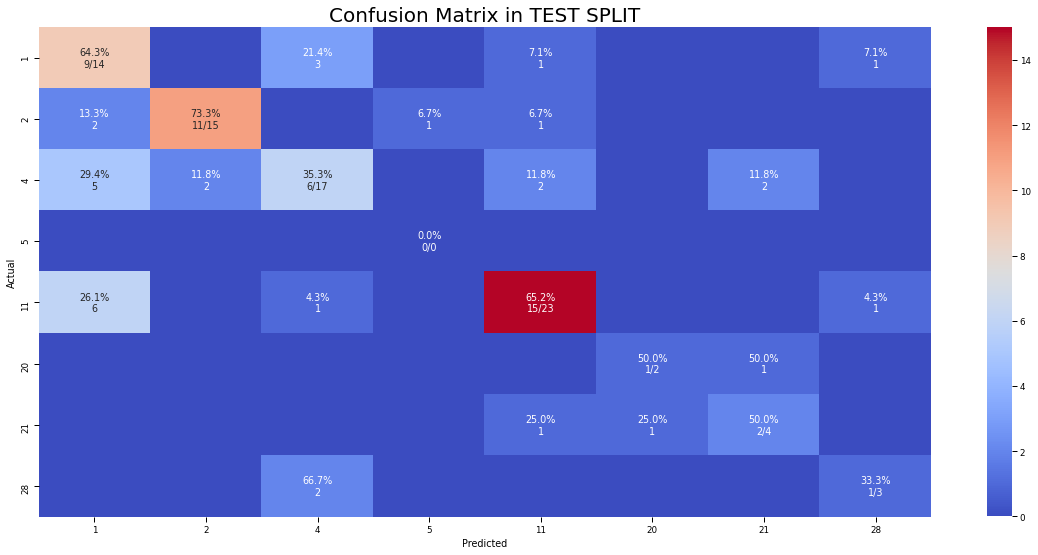

In [50]:
print("\033[1m-TRAIN\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(yy_train, yy_train_pred_xgb),4)))
print('Precision Score : ' + str(round(precision_score(yy_train, yy_train_pred_xgb,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(yy_train, yy_train_pred_xgb,average='macro'),4)))
print('F1 Score : ' + str(round(f1_score(yy_train, yy_train_pred_xgb,average='macro'),4)))
print("\033[1m-TEST\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(yy_test, yy_test_pred_xgb),4)))
print('Precision Score : ' + str(round(precision_score(yy_test, yy_test_pred_xgb,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(yy_test, yy_test_pred_xgb,average='macro'),4)))
print('F1 Score:' + str(round(f1_score(yy_test, yy_test_pred_xgb,average='macro'),4)))
print("\n\033[1m-Default parameters in the best trained model:\033[0m\n ", xgb_best_model)
print("\n\033[1m-Classification Report Test Split:\033[0m")
print(classification_report(yy_test, yy_test_pred_xgb))
plot_cm(yy_test_pred_xgb, yy_test)

## Descriptive Analysis

In comparision with the models_1 (without optimized hyperparameters) this model performs better, at least in its score. Like before, this model performed decently for a few classes, but was hit or miss with the rest. It also presents a reduced range of genres from which it picks to predict. The models performs better with samples corresponding with the classes 1, 2, 3, 11, 21. 

Most of the samples of the test set were of the classes 1,2 and 11. In these cases we see three diferent situations. for the class 1, the model was unable to properly distinguish between the rest of the well represented classes. for the class 2, the model succesfully learned to recognize it. for class 11, the model couldn't distinguish it from the class 1 samples.

In [51]:
#param grid all combinations
results_xgb = grid_xgb.cv_results_
df_xgb = pd.DataFrame(results_xgb)
df_xgb.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.188315,0.065150,0.006449,0.000270,0.6,0.5,3,1,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}",0.531915,0.489362,0.446809,0.489362,0.034745,16
1,0.152274,0.006262,0.006327,0.001048,0.6,0.5,3,1,1,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}",0.510638,0.478723,0.446809,0.478723,0.026058,31
2,0.244070,0.090448,0.006213,0.000160,0.6,0.5,3,5,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6}",0.542553,0.500000,0.457447,0.500000,0.034745,4


##### PCA XGBOOST

<Figure size 432x288 with 0 Axes>

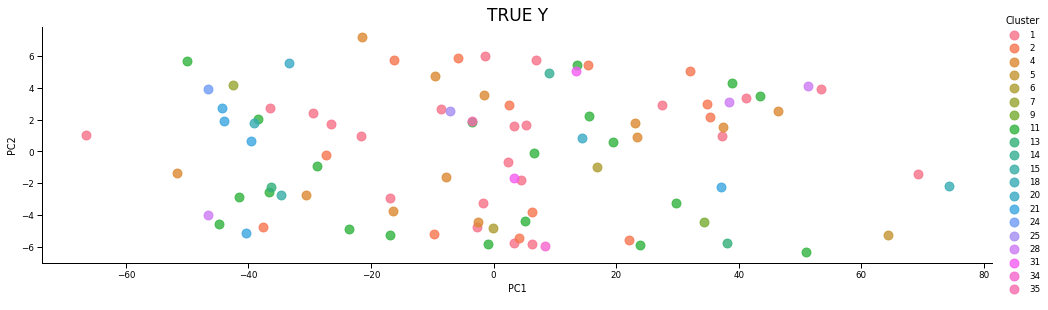

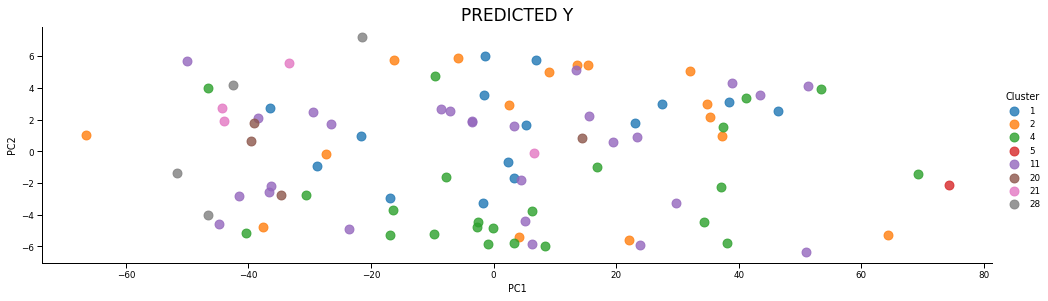

In [52]:
xx_test_xgb = XX_test
#TRUE
yy_test_xgb = yy_test
#PREDICTED
yy_test_pred_xgb

pca = decomposition.PCA(n_components=2)
pc1 = pca.fit_transform(xx_test_xgb)
pc2 = pca.fit_transform(xx_test_xgb)
df_pca1 = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC': ['PC1','PC2']})
df_pca2 = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC': ['PC1','PC2']})
#TRUE
pc_df1 = pd.DataFrame(data=pc1, columns=['PC1', 'PC2'])
pc_df1['Cluster']=yy_test_xgb.to_list()
#PREDICTED
pc_df2 = pd.DataFrame(data=pc2, columns=['PC1', 'PC2'])
pc_df2['Cluster']=yy_test_pred_xgb

plt.figure()
sns.lmplot(x='PC1', y='PC2', data=pc_df1,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("TRUE Y", fontsize=17)

sns.lmplot(x='PC1', y='PC2', data=pc_df2,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("PREDICTED Y", fontsize=17)
plt.show()

## Descriptive analysis

In these graphics we can see the genre range reduction very clearly. Tracking the individual examples we can detect some correct classifications, for the class 1,2,11 - which had the highest success rates.

This range reduction meant the model classified based on "broad strokes" and lost subtleity in most cases, grouping together songs which were originally labeled with different classes.

## Decision Trees

In [53]:
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4, 5], 
    "min_samples_split": [2, 3, 4]
}
grid_tree = GridSearchCV(dt_clf, param_grid_tree, scoring='accuracy', cv=3,verbose=1)
grid_tree.fit(XX_train, yy_train)

#making a prediction in train and test!
tree_best_model = grid_tree.best_estimator_
yy_train_pred_dt = tree_best_model.predict(XX_train)
yy_test_pred_dt = tree_best_model.predict(XX_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.7s finished


-TRAIN
Accuracy Score : 0.5248
Precision Score : 0.0625
Recall Score : 0.0901
F1 Score : 0.0736
-TEST
Accuracy Score : 0.4362
Precision Score : 0.0865
Recall Score : 0.1202
F1 Score:0.1003

-Default parameters in the best trained model:
  DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

-Classification Report Test Split:
              precision    recall  f1-score   support

           1       0.44      0.55      0.49        22
           2       0.53      0.69      0.60        13
           4       0.24      0.42      0.30        12
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.52      0.75      0.61        20
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
  

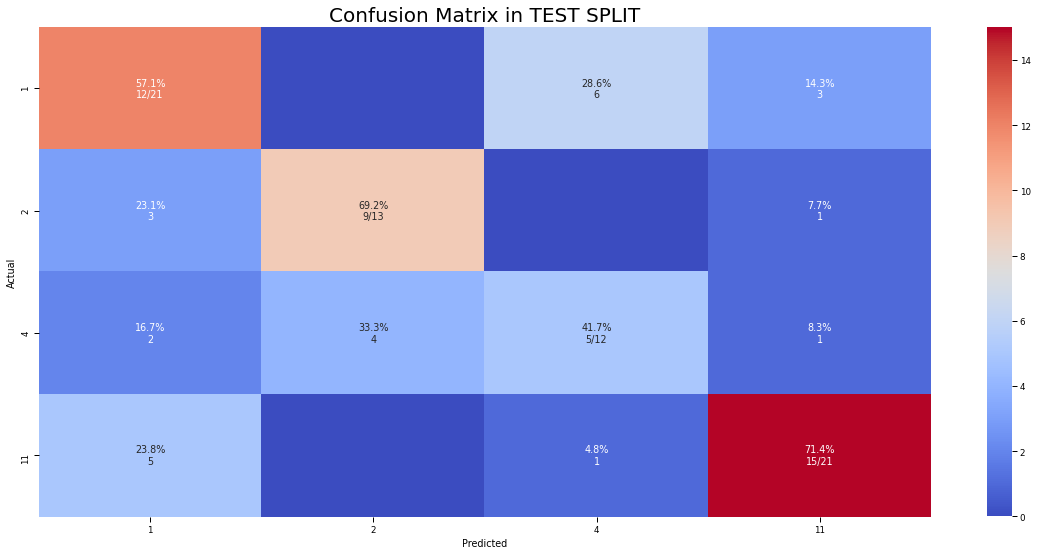

In [54]:
print("\033[1m-TRAIN\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(yy_train, yy_train_pred_dt),4)))
print('Precision Score : ' + str(round(precision_score(yy_train, yy_train_pred_dt,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(yy_train, yy_train_pred_dt,average='macro'),4)))
print('F1 Score : ' + str(round(f1_score(yy_train, yy_train_pred_dt,average='macro'),4)))
print("\033[1m-TEST\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(yy_test, yy_test_pred_dt),4)))
print('Precision Score : ' + str(round(precision_score(yy_test, yy_test_pred_dt,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(yy_test, yy_test_pred_dt,average='macro'),4)))
print('F1 Score:' + str(round(f1_score(yy_test, yy_test_pred_dt,average='macro'),4)))
print("\n\033[1m-Default parameters in the best trained model:\033[0m\n ", tree_best_model)
print("\n\033[1m-Classification Report Test Split:\033[0m")
print(classification_report(yy_test, yy_test_pred_dt))
plot_cm(yy_test_pred_dt, yy_test)

## Descriptive analysis

In this model, the forementioned range reduction is even more extreme. This model results in a very simple classification: out of the 35 different true genres, this model found the best to reduce this space to 4 different possible labels. This is a very different result than the one obtained through the default hyperparameters. It results in a higher accuracy score, through if optimizing the models with the accuracy in mind has as consequence a better classifier is out of scope of this exploration and deserves its own report. See Future Work for more on this. This higher accuracy score came with the cost of a lowered precision.

In [55]:
#param grid all combinations
results_dt = grid_tree.cv_results_
df_tree = pd.DataFrame(results_dt)
df_tree.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005420,0.000413,0.002848,0.000671,gini,1,2,"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}",0.276596,0.351064,0.308511,0.312057,0.030505,28
1,0.005535,0.000560,0.002466,0.000475,gini,1,3,"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 3}",0.276596,0.351064,0.308511,0.312057,0.030505,28
2,0.004800,0.000533,0.003134,0.000575,gini,1,4,"{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 4}",0.276596,0.351064,0.308511,0.312057,0.030505,28


##### PCA DecisionTrees

<Figure size 432x288 with 0 Axes>

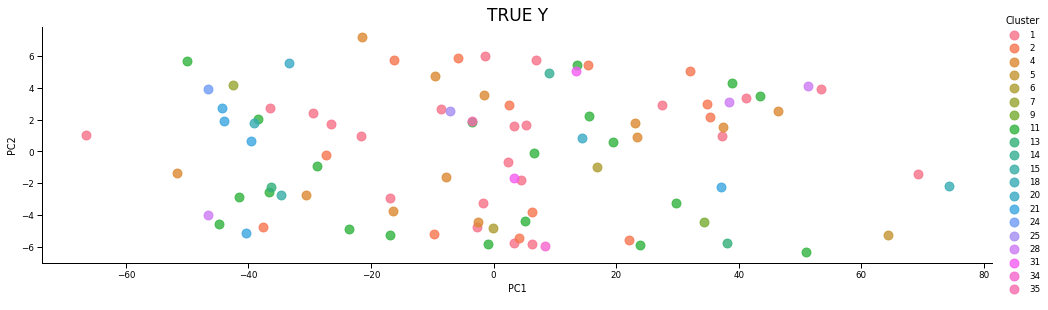

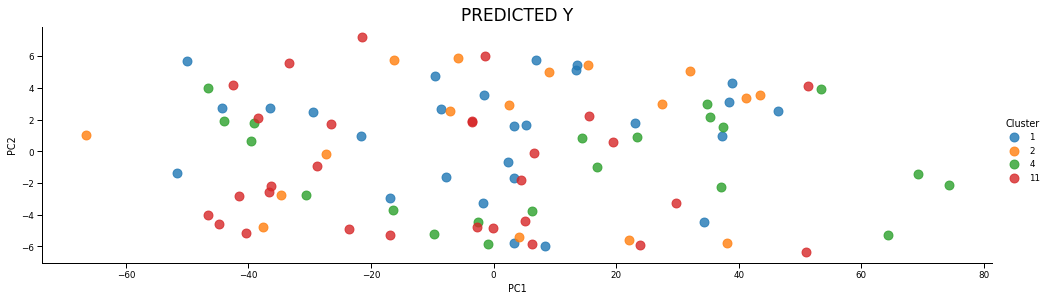

In [56]:
xx_test_dt = XX_test
#TRUE
yy_test_dt = yy_test
#PREDICTED
yy_test_pred_dt

pca = decomposition.PCA(n_components=2)
pc1 = pca.fit_transform(xx_test_dt)
pc2 = pca.fit_transform(xx_test_dt)
df_pca1 = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC': ['PC1','PC2']})
df_pca2 = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC': ['PC1','PC2']})

pc_df1 = pd.DataFrame(data=pc1, columns=['PC1', 'PC2'])
pc_df1['Cluster']=yy_test_dt.to_list()
pc_df2 = pd.DataFrame(data=pc2, columns=['PC1', 'PC2'])
pc_df2['Cluster']=yy_test_pred_dt

plt.figure()
sns.lmplot(x='PC1', y='PC2', data=pc_df1,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("TRUE Y", fontsize=17)

sns.lmplot(x='PC1', y='PC2', data=pc_df2,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("PREDICTED Y", fontsize=17)
plt.show()

# Descriptive Analysis

In these graphics we can see this forementioned heavy reduction of the dimensionality of the model's output more clearly.

It's as though this model sees everything through a simplifying filter. In some of the cases were there are new samples of these four overrepresented classes the model still makes mistakes; meaning it wasn't able to properly generalize, and the four classes aren't well distinguished.

## Random Forest

In [57]:
param_grid_rf= {
 'bootstrap': [True, False],
 'max_depth': [100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1,  4],
 'min_samples_split': [2, 10],
 'n_estimators': [200, 400]
}
grid_rf= GridSearchCV(rf_clf, param_grid_rf, scoring='accuracy', cv=3, verbose=1)
grid_rf.fit(XX_train, yy_train)

#making a prediction in train and test!
rf_best_model = grid_rf.best_estimator_
yy_train_pred_rf = rf_best_model.predict(XX_train)
yy_test_pred_rf = rf_best_model.predict(XX_test)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  1.3min finished


-TRAIN
Accuracy Score : 0.8085
Precision Score : 0.4216
Recall Score : 0.3042
F1 Score : 0.327
-TEST
Accuracy Score : 0.4894
Precision Score : 0.1737
Recall Score : 0.1734
F1 Score:0.1658

-Default parameters in the best trained model:
  RandomForestClassifier(max_depth=100, min_samples_leaf=4, n_estimators=200,
                       random_state=42)

-Classification Report Test Split:
              precision    recall  f1-score   support

           1       0.48      0.45      0.47        22
           2       0.73      0.85      0.79        13
           4       0.25      0.42      0.31        12
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.52      0.85      0.64        20
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15   

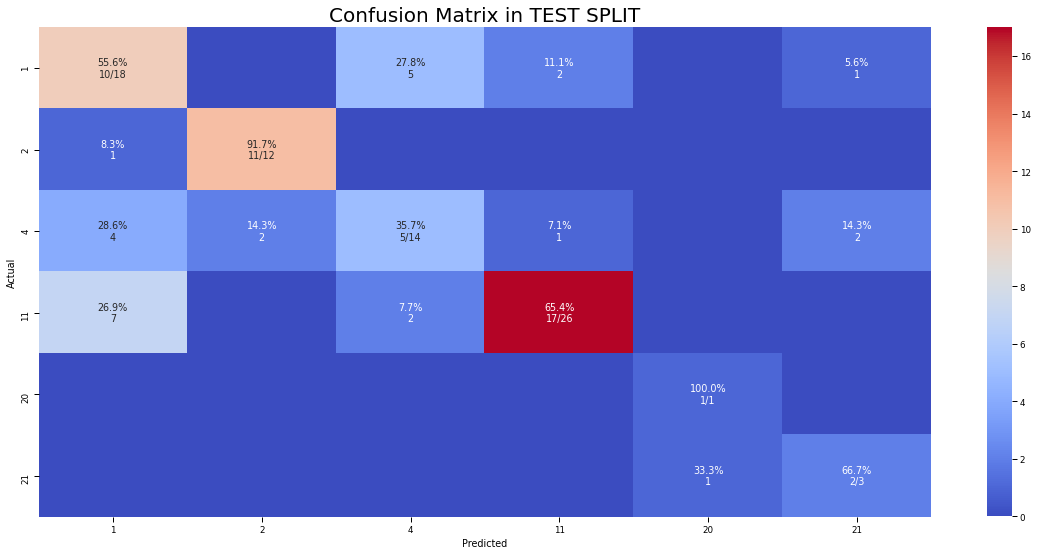

In [58]:
print("\033[1m-TRAIN\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(yy_train, yy_train_pred_rf),4)))
print('Precision Score : ' + str(round(precision_score(yy_train, yy_train_pred_rf,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(yy_train, yy_train_pred_rf,average='macro'),4)))
print('F1 Score : ' + str(round(f1_score(yy_train, yy_train_pred_rf,average='macro'),4)))
print("\033[1m-TEST\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(yy_test, yy_test_pred_rf),4)))
print('Precision Score : ' + str(round(precision_score(yy_test, yy_test_pred_rf,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(yy_test, yy_test_pred_rf,average='macro'),4)))
print('F1 Score:' + str(round(f1_score(yy_test, yy_test_pred_rf,average='macro'),4)))
print("\n\033[1m-Default parameters in the best trained model:\033[0m\n ", rf_best_model)
print("\n\033[1m-Classification Report Test Split:\033[0m")
print(classification_report(yy_test, yy_test_pred_rf))
plot_cm(yy_test_pred_rf, yy_test)

## Descriptive Analysis

This model has lower scores than the random forest with default parameters. In contrast, the one of this notebook seemed to overfit less. It also reduced the range of possible genres, but was able to distinguish very clearly  class 2 from the rest. Other classes present overlapping/confusion between eachother. This model could be transformed in a binary classifier: class 2 or not class 2.

In [59]:
#param grid all combinations
results_rf = grid_rf.cv_results_
df_rf = pd.DataFrame(results_rf)
df_rf.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.331202,0.062207,0.022317,0.002387,True,100,auto,1,2,200,"{'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.489362,0.478723,0.478723,0.48227,0.005015,53
1,0.624684,0.064925,0.049428,0.009283,True,100,auto,1,2,400,"{'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}",0.521277,0.478723,0.500000,0.50000,0.017372,17


<Figure size 432x288 with 0 Axes>

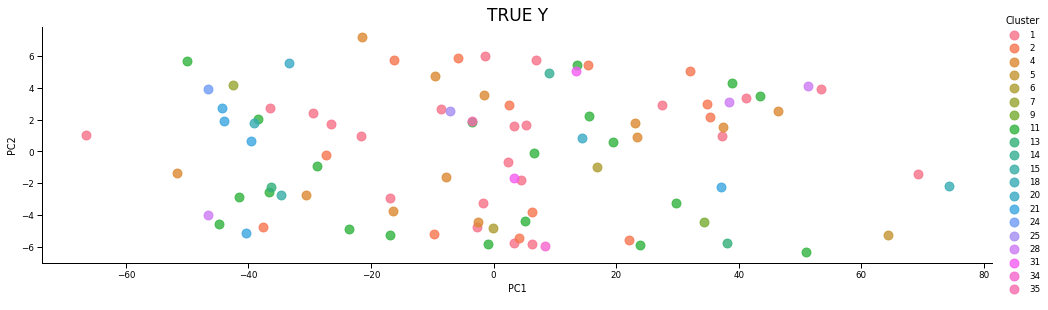

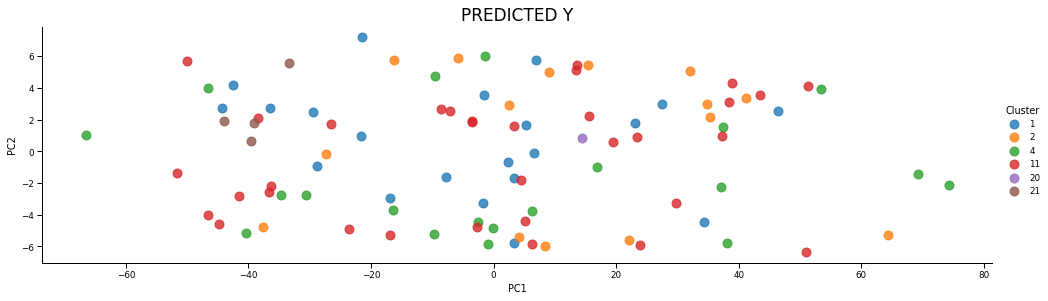

In [60]:
xx_test_rf = XX_test
#TRUE
yy_test_rf = yy_test
#PREDICTED
yy_test_pred_rf

pca = decomposition.PCA(n_components=2)
pc1 = pca.fit_transform(xx_test_rf)
pc2 = pca.fit_transform(xx_test_rf)
df_pca1 = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC': ['PC1','PC2']})
df_pca2 = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC': ['PC1','PC2']})

pc_df1 = pd.DataFrame(data=pc1, columns=['PC1', 'PC2'])
pc_df1['Cluster']=yy_test_rf.to_list()
pc_df2 = pd.DataFrame(data=pc2, columns=['PC1', 'PC2'])
pc_df2['Cluster']=yy_test_pred_rf

plt.figure()
sns.lmplot(x='PC1', y='PC2', data=pc_df1,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("TRUE Y", fontsize=17)

sns.lmplot(x='PC1', y='PC2', data=pc_df2,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("PREDICTED Y", fontsize=17)
plt.show()

## Descriptive analysis

Class 2 outputs shine through for being mostly correctly labeled. This model learned to identify that case in particular.

## Feature Importance

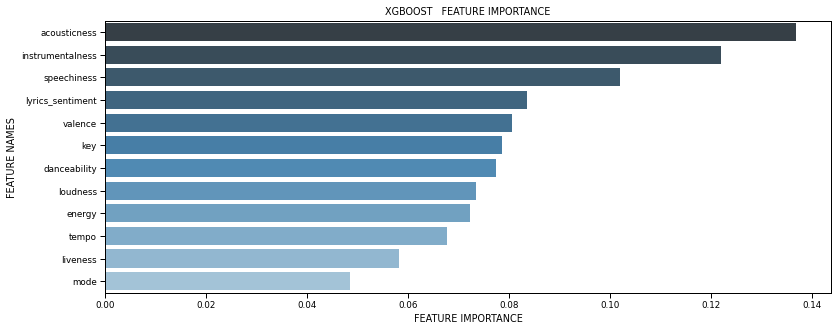

In [61]:
plot_feature_importance(xgb_best_model.feature_importances_, XX_train.columns,'XGBOOST   ')

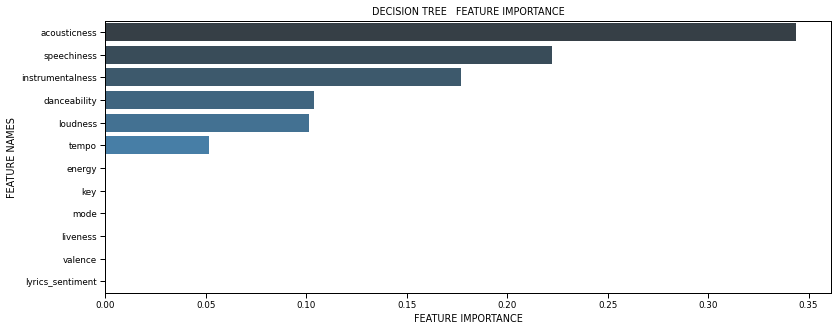

In [62]:
plot_feature_importance(tree_best_model.feature_importances_, XX_train.columns,'DECISION TREE   ')

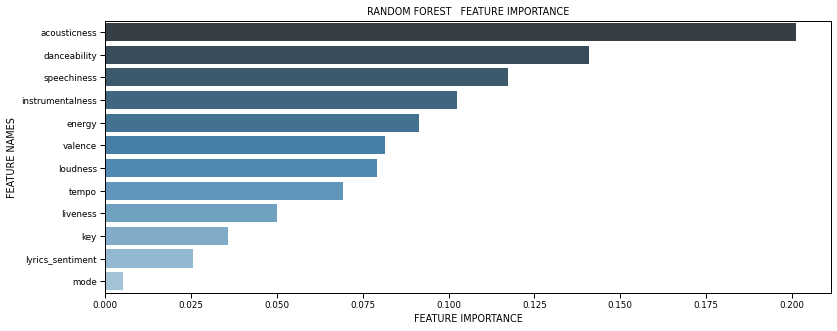

In [63]:
plot_feature_importance(rf_best_model.feature_importances_, XX_train.columns,'RANDOM FOREST   ')

In all cases, acousticness and speechiness were favored by the models in order to make classifications.

## Multiclass + Multilabel

In [64]:
# XX2=Features YY2=list of genres, target multilabel without encoding
XX2,YY2 = get_df_for_training(songs_base)

In [65]:
print(XX2.shape)
XX2.head(3)

(920, 12)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,lyrics_sentiment
0,0.161,0.482,1,-11.210,0,0.0472,0.486,0.40900,0.371,0.0926,161.092,0.0013
1,0.230,0.434,10,-12.402,0,0.0551,0.570,0.00000,0.115,0.0834,80.793,0.9970
2,0.289,0.280,9,-15.335,1,0.0433,0.874,0.00443,0.124,0.0391,124.835,0.0000


In [66]:
print(YY2.shape)
YY2.head(3)

(920,)


0    [art pop,  dance pop,  deconstructed club,  electropop,  escape room,  experimental pop,  fluxwork,  indie r&b,  indietronica]
1    [art pop,  dance pop,  deconstructed club,  electropop,  escape room,  experimental pop,  fluxwork,  indie r&b,  indietronica]
2    [art pop,  dance pop,  deconstructed club,  electropop,  escape room,  experimental pop,  fluxwork,  indie r&b,  indietronica]
Name: genres, dtype: object

In [67]:
binarizer = MultiLabelBinarizer()
yy2_binarized = binarizer.fit_transform(YY2)
X2_train, X2_test, y2_train, y2_test = model_selection.train_test_split(XX2, yy2_binarized , test_size=0.25, random_state=42)

## OneVsRestClassifier

In [68]:
import warnings
warnings.filterwarnings('ignore')

param_grid_ovr = {
              "estimator__alpha": [10**-5, 10**-3, 10**-1, 10**1, 10**2],
             }
ovr_clf = OneVsRestClassifier(
                SGDClassifier(
                    random_state=42,
                    loss='perceptron', #'log'
                    alpha=0.00001,
                    penalty="l2",
                    n_jobs=-1
                )
                  )
grid_ovr= GridSearchCV(ovr_clf, param_grid_ovr, scoring='accuracy', cv=3, verbose=1)
grid_ovr.fit(X2_train, y2_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    6.8s finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05,
                                                                   loss='perceptron',
                                                                   n_jobs=-1,
                                                                   random_state=42)),
             param_grid={'estimator__alpha': [1e-05, 0.001, 0.1, 10, 100]},
             scoring='accuracy', verbose=1)

In [69]:
#making a prediction in train and test!
ovr_best_model = grid_ovr.best_estimator_
y2_train_pred_ovr = ovr_best_model.predict(X2_train)
y2_test_pred_ovr = ovr_best_model.predict(X2_test)

In [70]:
ovr_clf.get_params().keys()

dict_keys(['estimator__alpha', 'estimator__average', 'estimator__class_weight', 'estimator__early_stopping', 'estimator__epsilon', 'estimator__eta0', 'estimator__fit_intercept', 'estimator__l1_ratio', 'estimator__learning_rate', 'estimator__loss', 'estimator__max_iter', 'estimator__n_iter_no_change', 'estimator__n_jobs', 'estimator__penalty', 'estimator__power_t', 'estimator__random_state', 'estimator__shuffle', 'estimator__tol', 'estimator__validation_fraction', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs'])

-TRAIN
Accuracy Score : 0.0116
Precision Score : 0.0248
Recall Score : 0.0224
F1 Score : 0.0203
-TEST
Accuracy Score : 0.0087
Precision Score : 0.0232
Recall Score : 0.0174
F1 Score:0.0164

-Default parameters in the best trained model:
  OneVsRestClassifier(estimator=SGDClassifier(alpha=100, loss='perceptron',
                                            n_jobs=-1, random_state=42))

-Classification Report Test Split:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.00      0.00      0.00         4
           2       0.06      0.04      0.05        28
           3       0.00      0.00      0.00         2
           4       0.11      0.02      0.03        54
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00    

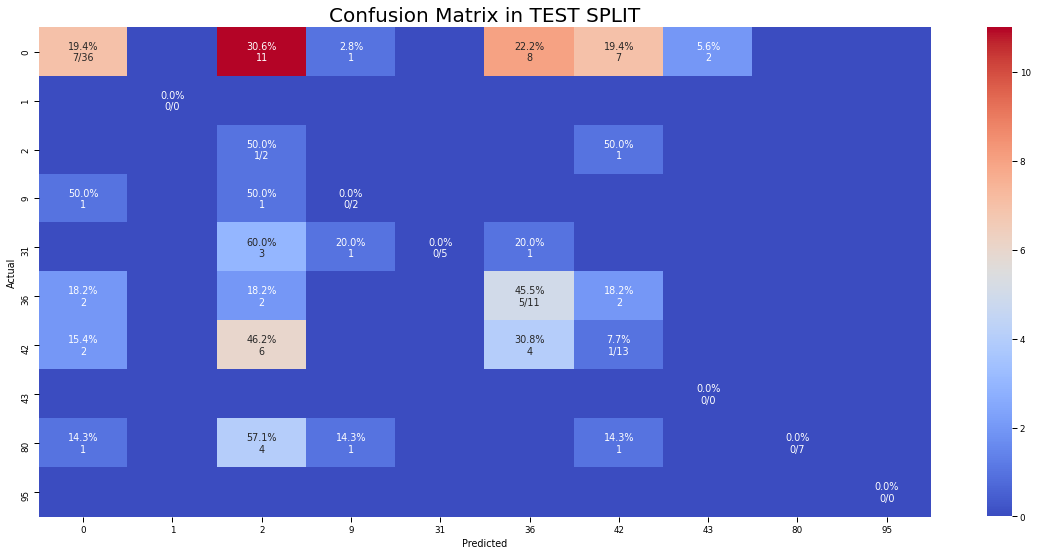

In [71]:
print("\033[1m-TRAIN\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y2_train, y2_train_pred_ovr),4)))
print('Precision Score : ' + str(round(precision_score(y2_train, y2_train_pred_ovr,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y2_train, y2_train_pred_ovr,average='macro'),4)))
print('F1 Score : ' + str(round(f1_score(y2_train, y2_train_pred_ovr,average='macro'),4)))
print("\033[1m-TEST\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y2_test, y2_test_pred_ovr),4)))
print('Precision Score : ' + str(round(precision_score(y2_test, y2_test_pred_ovr,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y2_test, y2_test_pred_ovr,average='macro'),4)))
print('F1 Score:' + str(round(f1_score(y2_test, y2_test_pred_ovr,average='macro'),4)))
print("\n\033[1m-Default parameters in the best trained model:\033[0m\n ", ovr_best_model)
print("\n\033[1m-Classification Report Test Split:\033[0m")
print(classification_report(y2_test, y2_test_pred_ovr))
plot_cm(y2_test_pred_ovr.argmax(axis=1), y2_test.argmax(axis=1))

## Descriptive analysis 
This model doesn't perform very well score-wise in general. It shows a wider range of possible genres, which might indicate that under the score-data representativeness trade off it decided to aim for the later: under the situation of having an unbalanced dataset (with a lot of samples of a few classes, and a lot of unique examples of a lot of classes) this model chose to not simplify the prediction, and it meant a reduction of its score.

In [72]:
#param grid all combinations
results_ovr = grid_ovr.cv_results_
df_ovr = pd.DataFrame(results_ovr)
df_ovr.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.360989,0.041636,0.114262,0.005224,1e-05,{'estimator__alpha': 1e-05},0.0,0.0,0.0,0.0,0.0,3
1,0.350292,0.019338,0.107588,0.004871,0.001,{'estimator__alpha': 0.001},0.0,0.0,0.0,0.0,0.0,3
2,0.443421,0.057667,0.142344,0.020752,0.1,{'estimator__alpha': 0.1},0.0,0.0,0.0,0.0,0.0,3


In [73]:
ovr_best_model.n_classes_

138

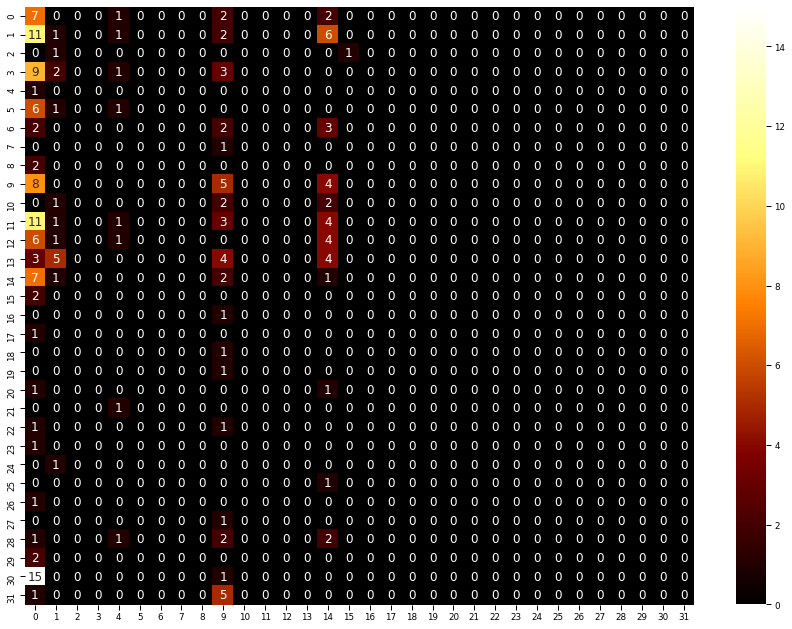

In [74]:
cm = confusion_matrix(y2_test.argmax(axis=1), y2_test_pred_ovr.argmax(axis=1), labels=np.unique(y2_test.argmax(axis=1)))
plt.figure(figsize=(15,11))
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap='afmhot') #bone plasma hot

## Descriptive Analysis
Even if the range of genres to be chosen was amplified in comparision to the non-multilabel models, this model still mostly chose 3 classes to classify the test samples. The performance of this model is in general very poor.

## Future Work and conclusions

This is a preliminary, first incursion into supervised learning. That means, most of the techniques applied in the reports were simple and could appear as clear pitfalls for a more experienced data scientist.

Still, this presented us with an array of problems to explore, and a lot of open-ended questions.

It could prove fruitful to reproduce this same notebook with a normalized dataset to see the difference. Even better, to find ways to balance the dataset and run this notebook with that version of it.

Another open ended question is what other different ways of seeing how good our model is for the classification problem. What type of visualizations could aid us to see this more clearly? In a related note, it was out of the scope of these explorations to find which score would be more accurate in order to search hyperparameters for our models. Still, this is a very interesting and useful topic that could lead to a useful classifier.